In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import train
import json


In [ ]:
dfList = train.transform("data.json")
#df.shape

In [ ]:
df1List = dfList
dfList = df1List
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)
#print(dfList[12])
#print(dfList[0].head(5))

In [2]:
def eval(accList, precisionList, tprList, farList, frrList, y, y_pred):
    avgaccuracy = 0
    avgPrecision = 0
    avgTpr = 0
    avgFar = 0
    avgFrr = 0
    for i in range(len(accList)):
        avgaccuracy += accList[i]
        avgPrecision += precisionList[i]
        avgTpr += tprList[i]
        avgFar += farList[i]
        avgFrr += frrList[i]
    avgaccuracy = avgaccuracy / len(accList)
    avgPrecision = avgPrecision / len(precisionList)
    avgTpr = avgTpr / len(tprList)
    avgFar = avgFar / len(farList)
    avgFrr = avgFrr / len(frrList)
    
    fprROC, tprROC, threshold = roc_curve(y, y_pred, pos_label=1) #fprROC == avgFar, tprROC == avgTpr
    fnrROC = 1 - tprROC #fnrROC == avgFrr
    EER = fprROC[np.nanargmin(np.absolute((fnrROC - fprROC)))]

    print("average acc = "+str(avgaccuracy))
    print("average precision = "+str(avgPrecision))
    print("average TPR = "+str(avgTpr))
    print("average FAR = "+str(avgFar))
    print("average FRR = "+str(avgFrr))
    print("average EER = "+str(EER))

In [ ]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['startX'])
    X = X.drop(columns=['startY'])
    X = X.drop(columns=['endX'])
    X = X.drop(columns=['endY'])

    X = X.drop(columns=['MXmax'])
    X = X.drop(columns=['MXmin'])
    X = X.drop(columns=['MXmean'])
    X = X.drop(columns=['MXmedian'])
    X = X.drop(columns=['MXSD'])
    X = X.drop(columns=['MYmax'])
    X = X.drop(columns=['MYmin'])
    X = X.drop(columns=['MYmean'])
    X = X.drop(columns=['MYmedian'])
    X = X.drop(columns=['MYSD'])
    X = X.drop(columns=['MZmax'])
    X = X.drop(columns=['MZmin'])
    X = X.drop(columns=['MZmean'])
    X = X.drop(columns=['MZmedian'])
    X = X.drop(columns=['MZSD'])

    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    #X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 36]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
    
eval(tnTotal, fpTotal, fnTotal, tpTotal, actual_targets.astype('int'), predicted_targets, len(dfList))

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()


In [ ]:
df = train.onlyOneUser("temp.json", "1094842")
#["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
#                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
#                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922"]
#scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
#df = scaler.transform(df)

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

y = df['label']
X = df.drop(columns=['label'])
X = X.drop(columns=['pressureMedian'])
X = X.drop(columns=['sizeMedian'])

predicted_targets = np.array([])
actual_targets = np.array([])

sess = rt.InferenceSession(
        f"./models/SMOTERF-newData/model9.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
    #print(X_test.astype(np.float32).to_dict('split')['data'])
    #break
y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

predicted_targets = np.append(predicted_targets, y_pred)
actual_targets = np.append(actual_targets, y)

cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
plt.figure(figsize=(12,5))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

tn, fp, fn, tp = cm.ravel()
tnTotal += tn
fpTotal += fp
fnTotal += fn
tpTotal += tp

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
tpr = tp/(tp+fn)
far = fp/(fp+tn)
frr = fn/(fn+tp)

accList.append(accuracy)
precisionList.append(precision)
tprList.append(tpr)
farList.append(far)
frrList.append(frr)

print("acc = "+str(accuracy))
print("precision = "+str(precision))
print("TPR = "+str(tpr))
print("FAR = "+str(far))
print("FRR = "+str(frr))
    
#eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)
#plt.figure(figsize=(12,5))
#sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
#plt.xlabel('Pred',fontsize=20)
#plt.ylabel('True',fontsize=20)
#plt.show()


In [ ]:
from sklearn.utils import shuffle

dfList = train.transform("data.json")

userList = ["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922", "29282928"]

with open("temp.json", 'r') as jsonFile:
        data = json.load(jsonFile)
        for user in data:
            index = userList.index(user)
            df = pd.DataFrame()
            df = train.onlyOneUser("temp.json", user)

            length = len(df)

            df = shuffle(df, random_state=42)
            df = df[:length//2] #first half for training, second half for testing

            dfList[index] = pd.concat([dfList[index], df])
            
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)

In [ ]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['startX'])
    X = X.drop(columns=['startY'])
    X = X.drop(columns=['endX'])
    X = X.drop(columns=['endY'])

    X = X.drop(columns=['MXmax'])
    X = X.drop(columns=['MXmin'])
    X = X.drop(columns=['MXmean'])
    X = X.drop(columns=['MXmedian'])
    X = X.drop(columns=['MXSD'])
    X = X.drop(columns=['MYmax'])
    X = X.drop(columns=['MYmin'])
    X = X.drop(columns=['MYmean'])
    X = X.drop(columns=['MYmedian'])
    X = X.drop(columns=['MYSD'])
    X = X.drop(columns=['MZmax'])
    X = X.drop(columns=['MZmin'])
    X = X.drop(columns=['MZmean'])
    X = X.drop(columns=['MZmedian'])
    X = X.drop(columns=['MZSD'])

    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    #X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    #import pickle
    #pickle.dump(RF_model, open(f"./models/rf{i}.pickle", "wb"))
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 36]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

In [3]:
dfList = train.transformSplit("temp.json")


110


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df3])


119


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


133


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


107


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


114


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


81


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


118


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


92


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


106


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


117


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


106


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


117


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


108


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


159


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


136


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


123


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


110


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


78


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


67


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


80


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


56


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


85


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


89


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


In [ ]:
dfList = train.transform("temp.json")

NOW SHOWING: 1092928


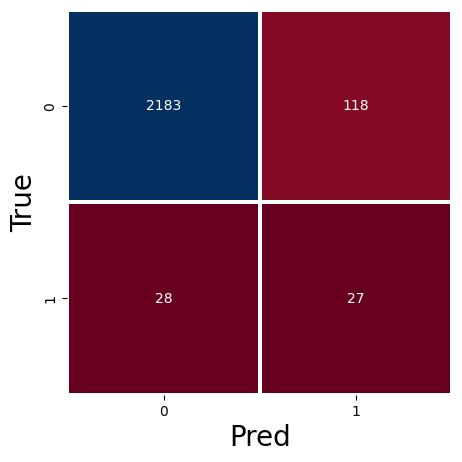

acc = 0.9380305602716469
precision = 0.18620689655172415
TPR = 0.4909090909090909
FAR = 0.05128205128205128
FRR = 0.509090909090909
NOW SHOWING: D1186959


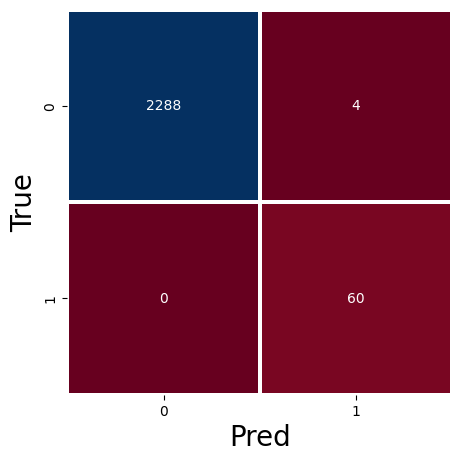

acc = 0.9982993197278912
precision = 0.9375
TPR = 1.0
FAR = 0.0017452006980802793
FRR = 0.0
NOW SHOWING: 1092922


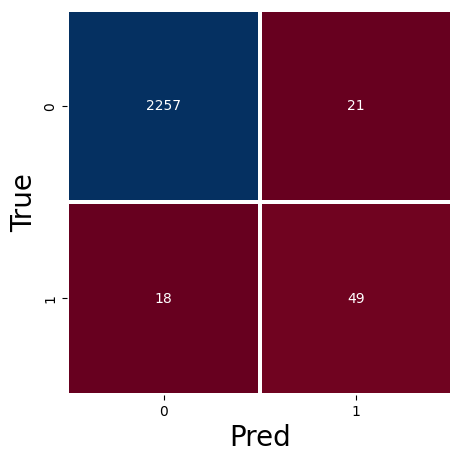

acc = 0.9833688699360341
precision = 0.7
TPR = 0.7313432835820896
FAR = 0.009218612818261633
FRR = 0.26865671641791045
NOW SHOWING: 1094841


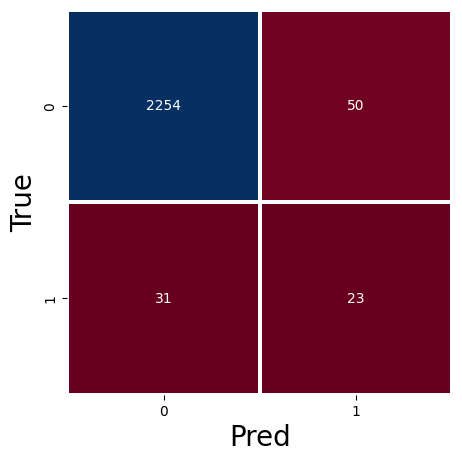

acc = 0.9656488549618321
precision = 0.3150684931506849
TPR = 0.42592592592592593
FAR = 0.021701388888888888
FRR = 0.5740740740740741
NOW SHOWING: 1094908


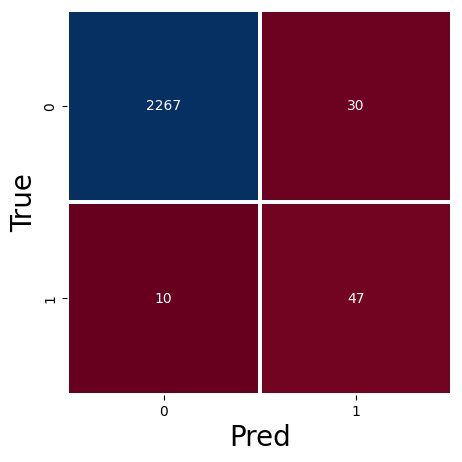

acc = 0.9830076465590484
precision = 0.6103896103896104
TPR = 0.8245614035087719
FAR = 0.013060513713539399
FRR = 0.17543859649122806
NOW SHOWING: lenny


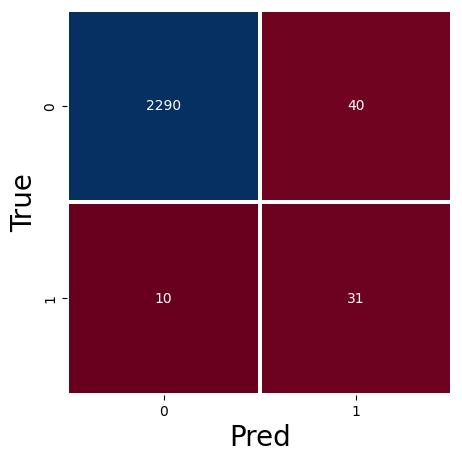

acc = 0.9789118515394348
precision = 0.43661971830985913
TPR = 0.7560975609756098
FAR = 0.017167381974248927
FRR = 0.24390243902439024
NOW SHOWING: dama0623


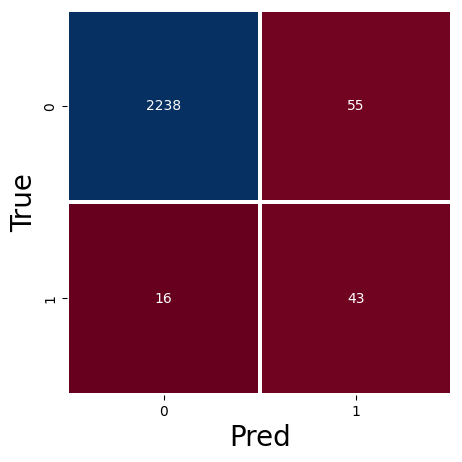

acc = 0.969812925170068
precision = 0.4387755102040816
TPR = 0.7288135593220338
FAR = 0.02398604448320977
FRR = 0.2711864406779661
NOW SHOWING: pomiii5093


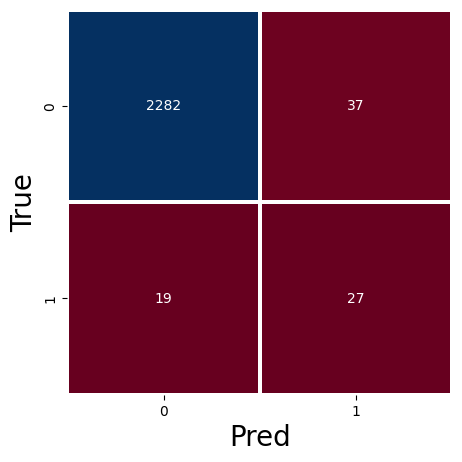

acc = 0.9763213530655391
precision = 0.421875
TPR = 0.5869565217391305
FAR = 0.015955153083225527
FRR = 0.41304347826086957
NOW SHOWING: 1092954


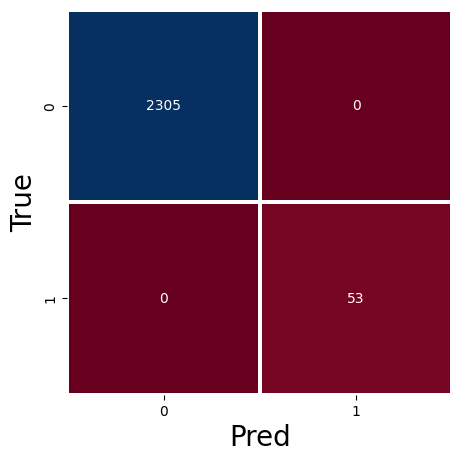

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
NOW SHOWING: 4109034029


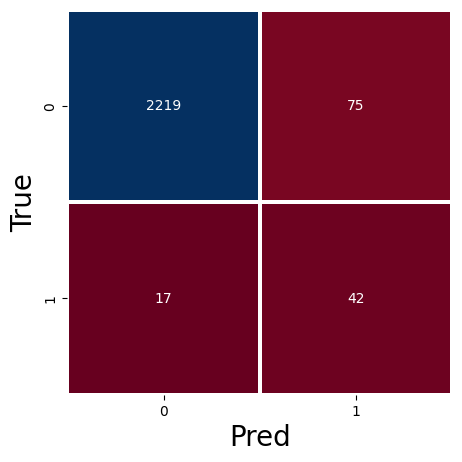

acc = 0.9609009774755631
precision = 0.358974358974359
TPR = 0.711864406779661
FAR = 0.03269398430688753
FRR = 0.288135593220339
NOW SHOWING: 110


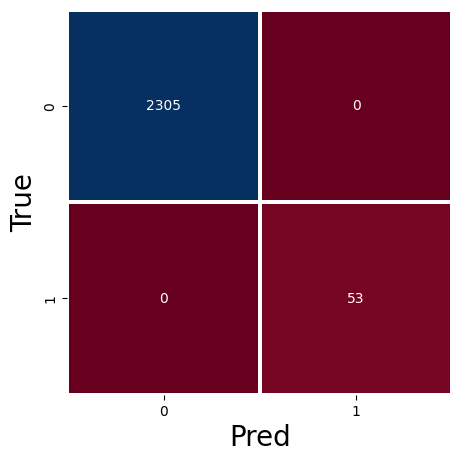

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
NOW SHOWING: 1094845


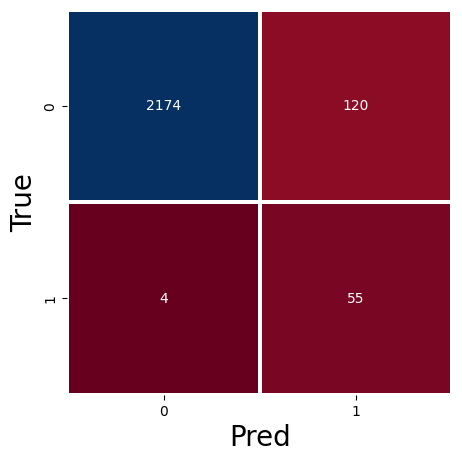

acc = 0.9473013174670634
precision = 0.3142857142857143
TPR = 0.9322033898305084
FAR = 0.05231037489102005
FRR = 0.06779661016949153
NOW SHOWING: 611034


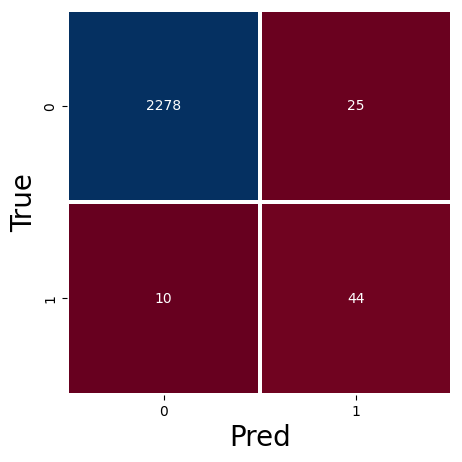

acc = 0.9851506151887993
precision = 0.6376811594202898
TPR = 0.8148148148148148
FAR = 0.010855405992184108
FRR = 0.18518518518518517
NOW SHOWING: 1092942


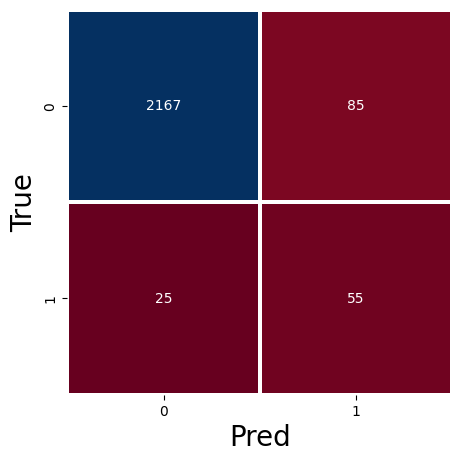

acc = 0.9528301886792453
precision = 0.39285714285714285
TPR = 0.6875
FAR = 0.03774422735346359
FRR = 0.3125
NOW SHOWING: 1092574


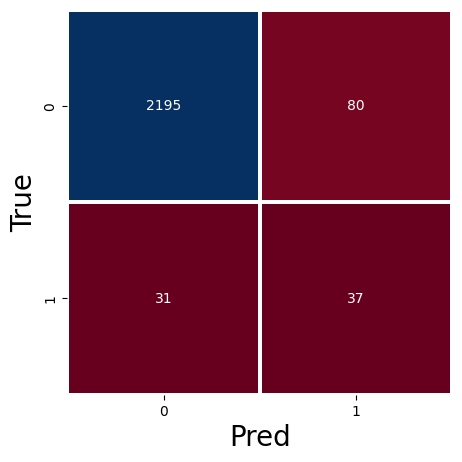

acc = 0.9526248399487837
precision = 0.3162393162393162
TPR = 0.5441176470588235
FAR = 0.035164835164835165
FRR = 0.45588235294117646
NOW SHOWING: 1092923


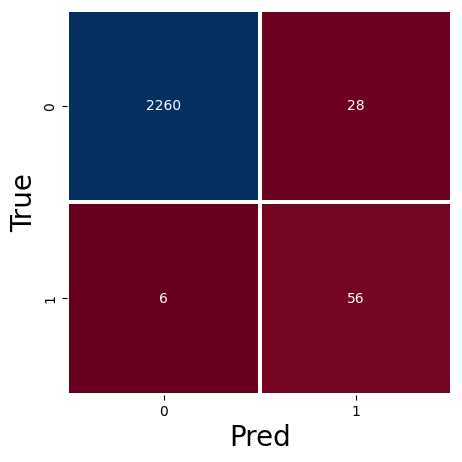

acc = 0.985531914893617
precision = 0.6666666666666666
TPR = 0.9032258064516129
FAR = 0.012237762237762238
FRR = 0.0967741935483871
NOW SHOWING: 411411159


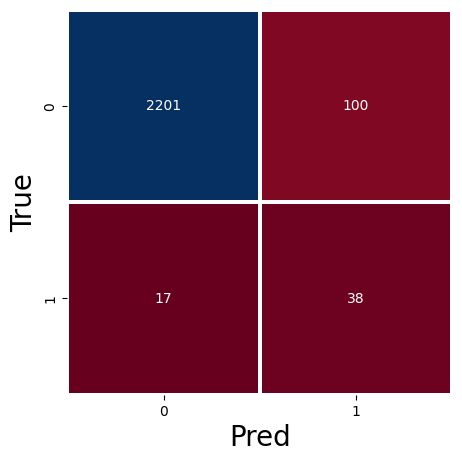

acc = 0.950339558573854
precision = 0.2753623188405797
TPR = 0.6909090909090909
FAR = 0.0434593654932638
FRR = 0.3090909090909091
NOW SHOWING: px


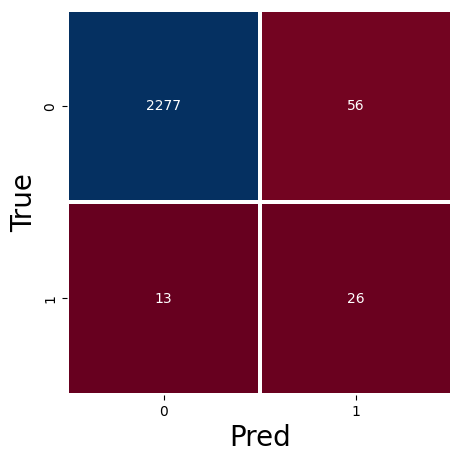

acc = 0.9709106239460371
precision = 0.3170731707317073
TPR = 0.6666666666666666
FAR = 0.02400342906129447
FRR = 0.3333333333333333
NOW SHOWING: anyu5471


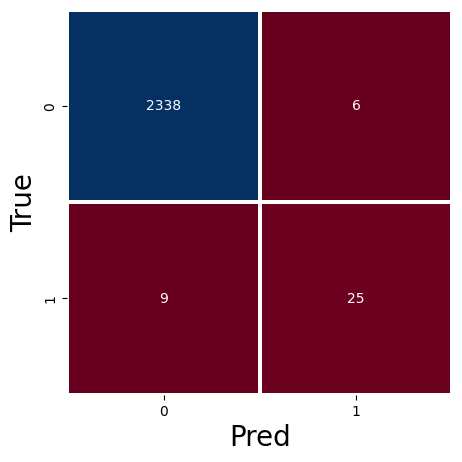

acc = 0.9936921783010934
precision = 0.8064516129032258
TPR = 0.7352941176470589
FAR = 0.002559726962457338
FRR = 0.2647058823529412
NOW SHOWING: 1094842


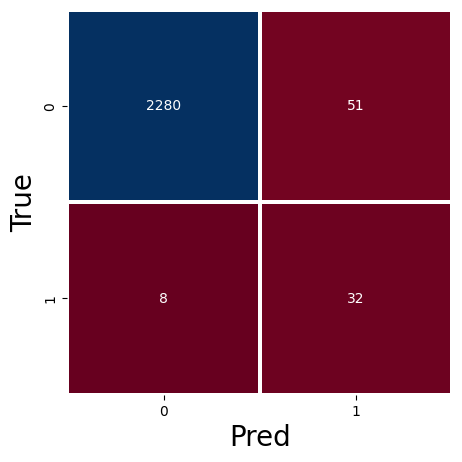

acc = 0.975115984816533
precision = 0.3855421686746988
TPR = 0.8
FAR = 0.021879021879021878
FRR = 0.2
NOW SHOWING: 1092950


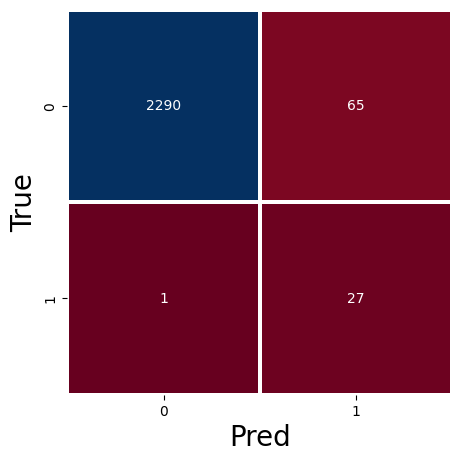

acc = 0.9723038187159043
precision = 0.29347826086956524
TPR = 0.9642857142857143
FAR = 0.027600849256900213
FRR = 0.03571428571428571
NOW SHOWING: 1092960


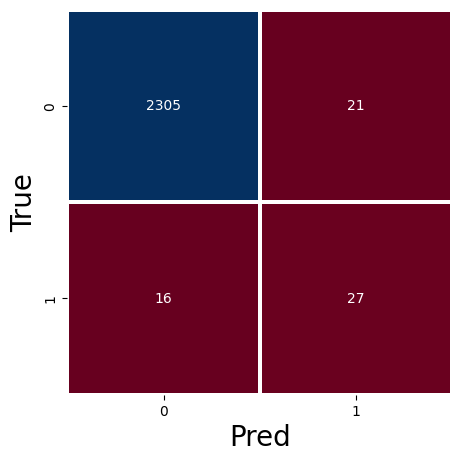

acc = 0.984381595609962
precision = 0.5625
TPR = 0.627906976744186
FAR = 0.009028374892519347
FRR = 0.37209302325581395
NOW SHOWING: 29282928


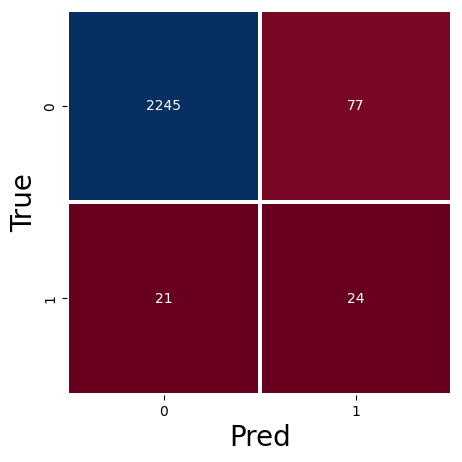

acc = 0.9585973806506126
precision = 0.2376237623762376
TPR = 0.5333333333333333
FAR = 0.03316106804478897
FRR = 0.4666666666666667
average acc = 0.9731774945868937
average precision = 0.5048335165845853
average TPR = 0.7459447526297447
average FAR = 0.021600642281648014
average FRR = 0.25405524737025553
average EER = 0.03316106804478897


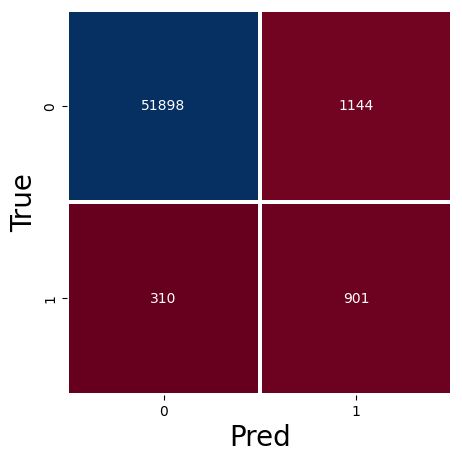

In [4]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import json

userOrder = []
userList = ["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922", "29282928"]

with open("evaluationData.json", 'r') as f:
    data = json.load(f)
    numSubject = len(data)
    for i in data.keys():
        userOrder.append(userList.index(i))
        
i=0

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

for df in dfList:
    y = df['label']
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['startX'])
    X = X.drop(columns=['startY'])
    X = X.drop(columns=['endX'])
    X = X.drop(columns=['endY'])

    X = X.drop(columns=['MXmax'])
    X = X.drop(columns=['MXmin'])
    X = X.drop(columns=['MXmean'])
    X = X.drop(columns=['MXmedian'])
    X = X.drop(columns=['MXSD'])
    X = X.drop(columns=['MYmax'])
    X = X.drop(columns=['MYmin'])
    X = X.drop(columns=['MYmean'])
    X = X.drop(columns=['MYmedian'])
    X = X.drop(columns=['MYSD'])
    X = X.drop(columns=['MZmax'])
    X = X.drop(columns=['MZmin'])
    X = X.drop(columns=['MZmean'])
    X = X.drop(columns=['MZmedian'])
    X = X.drop(columns=['MZSD'])

    predicted_targets = np.array([])
    actual_targets = np.array([])

    sess = rt.InferenceSession(
            #"./models/SMOTERF-newData/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            #f"./models/RandomSamplingRF-newData/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            f"./models/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
    
    input_name = sess.get_inputs()[0].name
        #print(X_test.astype(np.float32).to_dict('split')['data'])
        #break
    y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y)

    print("NOW SHOWING: " + str(userList[userOrder[i]]))
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)

    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)

    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()
